In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-metric-learning


In [ ]:
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES'
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)

# Reemplazar el prefijo "c." con nada en la columna 'date'
#df['date'] = df['date'].str.replace('c.', '').astype('int', errors='ignore')


print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


                  artist  date      genre  pixelsx  pixelsy  size_bytes  \
0  Ernst Ludwig Kirchner  1913  landscape   4908.0   3684.0  10682834.0   
1          Koloman Moser  1913  landscape   4716.0   3420.0  10933062.0   
2          Koloman Moser  1913  landscape   4722.0   3102.0   9018058.0   
3       Ferdinand Hodler  1913   portrait   3156.0   4638.0   8453089.0   
4          Koloman Moser  1913     design   4734.0   2622.0   8317658.0   

    source                 style  \
0  wikiart         Expressionism   
1  wikiart             Symbolism   
2  wikiart             Symbolism   
3  wikiart  Art Nouveau (Modern)   
4  wikiart  Art Nouveau (Modern)   

                                            title    artist_group  in_train  \
0                           Red Tree on the Beach  train_and_test      True   
1                                 Mountain ranges  train_and_test      True   
2                          Landscape in Semmering  train_and_test      True   
3      Valentine

In [ ]:
import os
import shutil
import random
import pandas as pd


In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_folder = os.path.join(folder, 'TRAIN')
  test_folder = os.path.join(folder, 'TEST')

  train_images = set(os.listdir(train_folder))
  test_images = set(os.listdir(test_folder))

  train_dataframe = df[df['new_filename'].isin(train_images)].copy()
  test_dataframe = df[df['new_filename'].isin(test_images)].copy()

  train_dataframe = train_dataframe[['new_filename', 'date']]
  test_dataframe = test_dataframe[['new_filename', 'date']]

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (1200, 2)
Test DataFrame: (300, 2)


In [ ]:
train_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1885,80
1,1888,80
2,1889,80
3,1890,80
4,1895,80
5,1907,80
6,1908,80
7,1909,80
8,1910,80
9,1911,80


In [ ]:
test_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1885,20
1,1888,20
2,1889,20
3,1890,20
4,1895,20
5,1907,20
6,1908,20
7,1909,20
8,1910,20
9,1911,20


In [ ]:
unique_dates = train_dataframe['date'].unique()
unique_dates
idx2date = {}
date2idx = {}

for i,date in enumerate(unique_dates):
  idx2date[i] = date
  date2idx[date] = i

print(idx2date)
print(date2idx)


{0: 1913, 1: 1912, 2: 1910, 3: 1914, 4: 1908, 5: 1890, 6: 1907, 7: 1888, 8: 1885, 9: 1911, 10: 1909, 11: 1889, 12: 1915, 13: 1917, 14: 1895}
{1913: 0, 1912: 1, 1910: 2, 1914: 3, 1908: 4, 1890: 5, 1907: 6, 1888: 7, 1885: 8, 1911: 9, 1909: 10, 1889: 11, 1915: 12, 1917: 13, 1895: 14}


In [ ]:
for index, row in train_dataframe.iterrows():
    train_dataframe.at[index, 'date'] = date2idx[row['date']]

for index, row in test_dataframe.iterrows():
    test_dataframe.at[index, 'date'] = date2idx[row['date']]

print("Train DataFrame:")
print(train_dataframe.head())

print("\nTest DataFrame:")
print(test_dataframe.head())


Train DataFrame:
  new_filename  date
0    51728.jpg     0
1    43030.jpg     0
4    51408.jpg     0
6    96668.jpg     0
7    42047.jpg     0

Test DataFrame:
   new_filename  date
2     12455.jpg     0
3     65887.jpg     0
5     85069.jpg     0
27    32734.jpg     0
33    68230.jpg     0


In [ ]:
idx2date

{0: 1913,
 1: 1912,
 2: 1910,
 3: 1914,
 4: 1908,
 5: 1890,
 6: 1907,
 7: 1888,
 8: 1885,
 9: 1911,
 10: 1909,
 11: 1889,
 12: 1915,
 13: 1917,
 14: 1895}

In [ ]:
'''
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657], std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])  # Normalization for color images
])
# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()
# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []
#if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):

  # Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['date'].iloc[0]
    train_labels.append(label)

# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['date'].iloc[0]
    test_labels.append(label)

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.stack(train_images), train_labels_tensor)
test_dataset = TensorDataset(torch.stack(test_images), test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)
'''

"\nimport os\nfrom PIL import Image\nimport torch\nfrom torchvision import transforms\nfrom torch.utils.data import DataLoader, TensorDataset\nimport pandas as pd\nimport torch.nn as nn\nimport torch.optim as optim\nimport torch.nn.functional as F\nfrom pytorch_metric_learning import distances, losses, miners, reducers, testers\nfrom pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator\n\n# Define the transformation to convert images to PyTorch tensors\ntransf = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657], std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])  # Normalization for color images\n])\n# Paths of the training and testing folders\ntrain_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN'\ntest_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TEST'\n\n# Get the f

In [ ]:
'''
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, labels, class_name, num_images=4):
    # Find indices of images belonging to the specified class
    class_indices = [idx for idx, label in enumerate(labels) if label == class_name]
    # Randomly select 4 indices
    selected_indices = np.random.choice(class_indices, num_images)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f"Class {class_name} Images")
    for i, idx in enumerate(selected_indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Example: Show 4 images of class 0 from the training set
show_images(train_dataset, train_labels_tensor, class_name=1913)

# Example: Show 4 images of class 1 from the testing set
show_images(test_dataset, test_labels_tensor, class_name=1913)
'''

'\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ndef show_images(dataset, labels, class_name, num_images=4):\n    # Find indices of images belonging to the specified class\n    class_indices = [idx for idx, label in enumerate(labels) if label == class_name]\n    # Randomly select 4 indices\n    selected_indices = np.random.choice(class_indices, num_images)\n\n    # Plot the images\n    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))\n    fig.suptitle(f"Class {class_name} Images")\n    for i, idx in enumerate(selected_indices):\n        img, label = dataset[idx]\n        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization\n        axes[i].imshow(img)\n        axes[i].axis(\'off\')\n    plt.show()\n\n# Example: Show 4 images of class 0 from the training set\nshow_images(train_dataset, train_labels_tensor, class_name=1913)\n\n# Example: Show 4 images of class 1 from the testing set\nshow_images(test_dataset, test_labels_tensor, class_name=

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator



# NETWORK

In [ ]:
from pytorch_metric_learning import losses

In [ ]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 110 * 110, NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0.0  # Inicializa la pérdida acumulada en la época

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Acumula la pérdida del lote en la pérdida de la época

    epoch_loss /= len(train_loader)  # Calcula el promedio de la pérdida de la época
    print("Epoch {}: Average Loss = {}".format(epoch, epoch_loss))  # Imprime la pérdida promedio de la época

    return epoch_loss  # Devuelve la pérdida promedio de la época

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator, loss_func,):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies["precision_at_1"]


In [ ]:
# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES/TEST'

In [ ]:
device = torch.device("cuda")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657], std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])  # Normalization for color images
])

In [ ]:
batch_size = 50

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image


# Define la clase Dataset personalizada para cargar tus datos
class CustomDataset(Dataset):
    def __init__(self, dataframe, folder, transform=None):
        self.dataframe = dataframe
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        date = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, date


# Definir las rutas de las carpetas de entrenamiento y prueba
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP15_DATAS_WITH_100_PICTURES/TEST'

# Crear instancias del conjunto de datos personalizado
train_dataset = CustomDataset(train_dataframe, train_folder, transform=transform)
test_dataset = CustomDataset(test_dataframe, test_folder, transform=transform)

# Crear los DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

## Les 2 celas comentades shan de fer servir si es vol utilitzar la versio de la funcio "test" que NO fa el %. Primer, s'ha de fer els 2 unistall y despres els 2 install i reiniciar entorno ejecucion (ho demanara sol).


In [ ]:
!pip uninstall faiss-gpu
!pip uninstall faiss-cpu

Found existing installation: faiss-gpu 1.7.2
Uninstalling faiss-gpu-1.7.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/faiss/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu-1.7.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libz-745e0a09.so.1.2.7
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx2.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx512.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/array_conversions.py
    /usr/local/lib/python3.10/dist-packages/faiss/class_wrappers.py
    /usr/local/lib/python3.10/dist-packages/faiss/contrib

In [ ]:
!pip install faiss-gpu
!pip install faiss-cpu

  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (85.5 MB)


  Using cached faiss_cpu-1.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (27.0 MB)
ERROR: Operation cancelled by user


In [ ]:
import faiss
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning import miners, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity, LpDistance
from pytorch_metric_learning.reducers import ThresholdReducer
import matplotlib.pyplot as plt
import faiss


accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

Epoch 1: Average Loss = 25.399313166737556


100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Computing accuracy


/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Test set accuracy (Precision@1) = 0.1366666666666667
Epoch 2: Average Loss = 2.981855516632398


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.07333333333333333
Epoch 3: Average Loss = 1.5361408491929371


100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.10666666666666667
Epoch 4: Average Loss = 1.0652238925298054


100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.06333333333333334
Epoch 5: Average Loss = 0.8401820237437884


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.08333333333333334
Epoch 6: Average Loss = 0.7685256352027258


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.10666666666666667
Epoch 7: Average Loss = 0.7217980325222015


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.08333333333333334
Epoch 8: Average Loss = 0.6978293433785439


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.11333333333333334
Epoch 9: Average Loss = 0.6861732477943102


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.11666666666666667
Epoch 10: Average Loss = 0.6629718542098999


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.13
Epoch 11: Average Loss = 0.6498778785268465


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.10333333333333335
Epoch 12: Average Loss = 0.6514908969402313


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.10333333333333335
Epoch 13: Average Loss = 0.6396329378088316


100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.10333333333333335
Epoch 14: Average Loss = 0.636347363392512


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.08666666666666667
Epoch 15: Average Loss = 0.6099427056809267


100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.11666666666666667
[25.399313166737556, 2.981855516632398, 1.5361408491929371, 1.0652238925298054, 0.8401820237437884, 0.7685256352027258, 0.7217980325222015, 0.6978293433785439, 0.6861732477943102, 0.6629718542098999, 0.6498778785268465, 0.6514908969402313, 0.6396329378088316, 0.636347363392512, 0.6099427056809267]
[0.1366666666666667, 0.07333333333333333, 0.10666666666666667, 0.06333333333333334, 0.08333333333333334, 0.10666666666666667, 0.08333333333333334, 0.11333333333333334, 0.11666666666666667, 0.13, 0.10333333333333335, 0.10333333333333335, 0.10333333333333335, 0.08666666666666667, 0.11666666666666667]


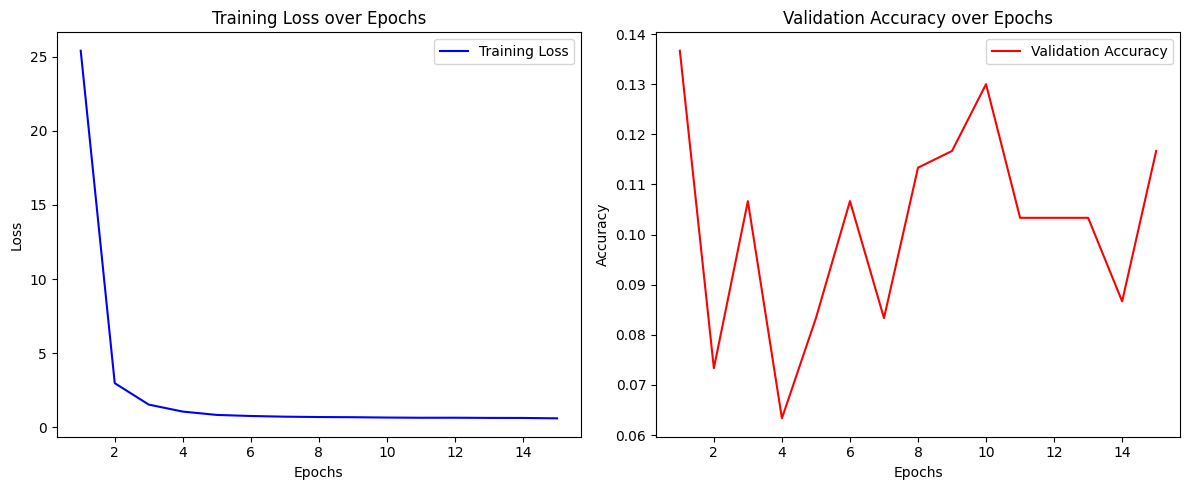

In [ ]:
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
import matplotlib.pyplot as plt


def plot_metrics(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, 'b-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
num_epochs = 10

# Pytorch-metric-learning configurations
distance = LpDistance()
reducer = ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(),
                                    reducer = ThresholdReducer(high=0.3),
                                    embedding_regularizer = LpRegularizer())
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="hard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=2)

losses_over_epochs = []
acc_over_epochs=[]
# Training and testing
for epoch in range(1, num_epochs + 1):
    epoch_loss = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    losses_over_epochs.append(epoch_loss)
    acc=test(train_dataset, test_dataset, model, accuracy_calculator, loss_func)
    acc_over_epochs.append(acc)
print(losses_over_epochs)
print(acc_over_epochs)
plot_metrics(losses_over_epochs,acc_over_epochs)

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Ruta de la carpeta de prueba
test_folder = os.path.join(folder, "TEST")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño de la imagen según la entrada del modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657],
                         std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])
])

# Función para predecir la clase de una imagen
def predict_class(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Añade una dimensión adicional para el batch
    image = image.to(device)

    with torch.no_grad():
        model.eval()
        output = model(image)

    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities).item()

    return predicted_class

i = 0
ll_predicted = []
ll_real = []
# Iterar sobre todas las imágenes en la carpeta de prueba
for filename in os.listdir(test_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_folder, filename)
        predicted_class = predict_class(image_path, model, transform, device)

        # Obtener la clase real
        real_class = test_dataframe[test_dataframe['new_filename'] == filename]['date'].tolist()[0]

        predicted = idx2date[predicted_class]
        real = idx2date[real_class]
        if predicted == real:
            i += 1

        ll_predicted.append(predicted)
        ll_real.append(real)
        print(f"Imagen: {filename}")
        print(f"Clase predicha: {predicted}")
        print(f"Clase real: {real}")
        print("-------------------------")



Imagen: 12455.jpg
Clase predicha: 1912
Clase real: 1913
-------------------------
Imagen: 85069.jpg
Clase predicha: 1915
Clase real: 1913
-------------------------
Imagen: 65887.jpg
Clase predicha: 1914
Clase real: 1913
-------------------------
Imagen: 32734.jpg
Clase predicha: 1910
Clase real: 1913
-------------------------
Imagen: 68230.jpg
Clase predicha: 1912
Clase real: 1913
-------------------------
Imagen: 100030.jpg
Clase predicha: 1895
Clase real: 1913
-------------------------
Imagen: 60263.jpg
Clase predicha: 1908
Clase real: 1913
-------------------------
Imagen: 65592.jpg
Clase predicha: 1888
Clase real: 1913
-------------------------
Imagen: 2246.jpg
Clase predicha: 1895
Clase real: 1913
-------------------------
Imagen: 99196.jpg
Clase predicha: 1912
Clase real: 1913
-------------------------
Imagen: 23260.jpg
Clase predicha: 1911
Clase real: 1913
-------------------------
Imagen: 60353.jpg
Clase predicha: 1914
Clase real: 1913
-------------------------
Imagen: 97206.jp

In [ ]:
import numpy as np

def calculate_mae(ll_predicted, ll_real):
    # Asegurarse de que las listas tengan la misma longitud
    assert len(ll_predicted) == len(ll_real), "Las listas deben tener la misma longitud"

    # Convertir listas a numpy arrays para facilitar el cálculo
    ll_predicted = np.array(ll_predicted)
    ll_real = np.array(ll_real)

    # Calcular el MAE
    mae = np.mean(np.abs(ll_predicted - ll_real))

    return mae


print("Total acertades:",str(i)+"/"+str(len(os.listdir(test_folder))))
print("Percetnatge acertat:",(i * 100)/len(os.listdir(test_folder)))
mae = calculate_mae(ll_predicted, ll_real)
print(f"MAE: {mae}")


Total acertades: 21/300
Percetnatge acertat: 7.0
MAE: 11.276666666666667
